In [1]:
import os
import load_dataset
import torch.nn as nn
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
pretrained_model = torch.load('model_storage/pretrained_clip.pt')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_compare = load_dataset.get_dataframe('test')[['category_name', 'image_file']].sample(10, random_state=200)

In [3]:
def visualize_similarity(using_pretrained=True):

    image_embeddings = []
    text_embeddings = []
    images = []
    texts = []

    for row in df_compare.itertuples(index=True):

        text = row.category_name
        texts.append(text)

        image = Image.open(row.image_file).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).cuda()
        images.append(image)

        with torch.no_grad():
            if using_pretrained:
                image_embedding = pretrained_model.encode_image(image_input).float()
                text_embedding = pretrained_model.encode_text(clip.tokenize(text).to(device)).float()
            else:
                image_embedding = model.encode_image(image_input).float()
                text_embedding = model.encode_text(clip.tokenize(text).to(device)).float()
                
        image_embedding /= image_embedding.norm(dim=-1, keepdim=True)
        text_embedding /= text_embedding.norm(dim=-1, keepdim=True)

        image_embeddings.append(image_embedding.cpu().numpy())
        text_embeddings.append(text_embedding.cpu().numpy())
        
    similarity = np.zeros((len(images), len(images)), dtype=float)
    for i, image_embedding in enumerate(image_embeddings):
        for j, text_embedding in enumerate(text_embeddings):
            dot = image_embedding @ text_embedding.T
            similarity[i, j] = dot
            
    count = len(texts)
    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
        plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title(f"Cosine similarity between text and image embeddings {'using' if using_pretrained is True else 'not using'} pretrained model", size=20)
    plt.show()

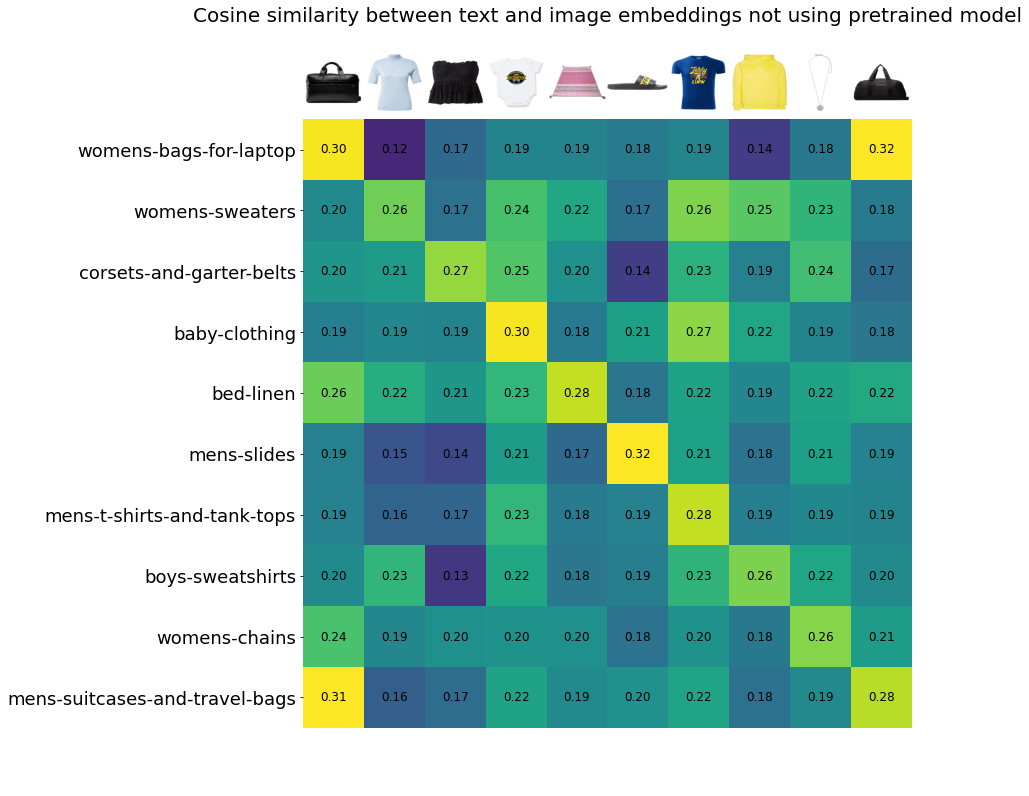

In [4]:
visualize_similarity(using_pretrained=False)

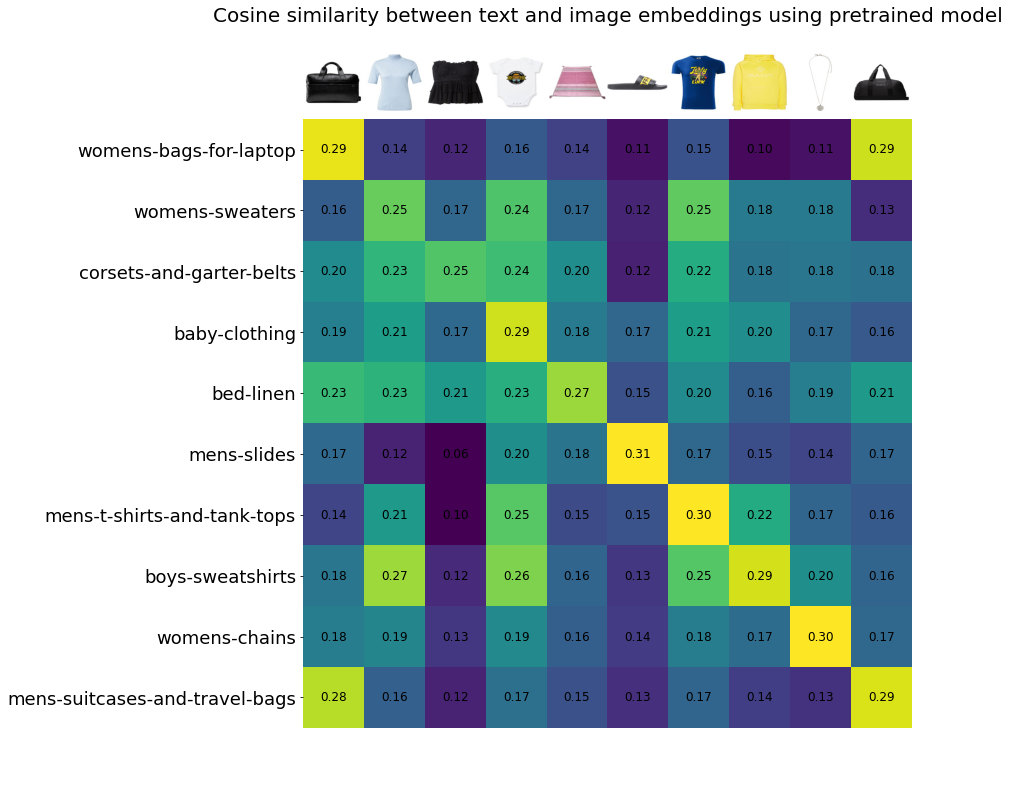

In [5]:
visualize_similarity(using_pretrained=True)